# Ray et al 2013 Evaluation
**Authorship:**
Adam Klie, *08/31/2022*
***
**Description:**
Notebook to evaluate trained models on the Ray et al dataset.
***

In [122]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
eu.settings.dataset_dir = "../../../_datasets/ray13"
eu.settings.output_dir = "../../../_output/ray13"
eu.settings.logging_dir = "../../../_logs/ray13"
eu.settings.config_dir = "../../../_configs/ray13"
figure_dir = "../../../_figures/ray13"
eu.settings.verbosity = logging.ERROR

# Load in the test `SeqData`

In [212]:
# Load the test data
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, "norm_setB_sub.h5sd"))
target_mask = sdata_test.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_test.seqs_annot.columns[target_mask]
sdata_test

SeqData object with = 100 seqs
seqs = (100,)
names = (100,)
rev_seqs = None
ohe_seqs = (100, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004', 'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00011', 'RNCMPT00012', 'RNCMPT00013', 'RNCMPT00014', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00017', 'RNCMPT00018', 'RNCMPT00019', 'RNCMPT00020', 'RNCMPT00021', 'RNCMPT00022', 'RNCMPT00023', 'RNCMPT00024', 'RNCMPT00025', 'RNCMPT00026', 'RNCMPT00027', 'RNCMPT00028', 'RNCMPT00029', 'RNCMPT00031', 'RNCMPT00032', 'RNCMPT00033', 'RNCMPT00034', 'RNCMPT00035', 'RNCMPT00036', 'RNCMPT00037', 'RNCMPT00038', 'RNCMPT00039', 'RNCMPT00040', 'RNCMPT00041', 'RNCMPT00042', 'RNCMPT00043', 'RNCMPT00044', 'RNCMPT00045', 'RNCMPT00046', 'RNCMPT00047', 'RNCMPT00049', 'RNCMPT00050', 'RNCMPT00051', 'RNCMPT00052', 'RNCMPT00053', 'RNCMPT00054', 'RNCMPT00055', 'RNCMPT00056', 'RNCMPT00057', 'RNCMPT00058', 'RNCMPT00059', 

In [127]:
b_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetB_binary.npy"))
setB_observed = sdata_test.seqs_annot[target_cols]

# Get test set predictions for each model

## SetA 

In [ ]:
a_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetA_binary.npy"))
setA_observed = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_sub.h5sd")).seqs_annot[target_cols]

In [128]:
a_metr = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)
b_metr = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/100 [00:00<?, ?it/s]

In [200]:
from scipy.stats import pearsonr, spearmanr
pearson_setA_long = pd.DataFrame()
spearman_setA_long = pd.DataFrame()
for task in target_cols[:5]:
    a_zscores, a_aucs, a_escores  = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed[task].values, verbose=False, use_calc_auc=True, num_kmers=100)
    b_zscores, b_aucs, b_escores = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed[task].values, verbose=False, use_calc_auc=True, num_kmers=100) 
    
    zscore_nan_mask = np.isnan(a_zscores) | np.isnan(b_zscores)
    a_zscores = a_zscores[~zscore_nan_mask]
    b_zscores = b_zscores[~zscore_nan_mask]
    if len(a_zscores) > 0 and len(b_zscores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Pearson": pearsonr(a_zscores, b_zscores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Spearman": spearmanr(a_zscores, b_zscores)[0]}), ignore_index=True)
    

    auc_nan_mask = np.isnan(a_aucs) | np.isnan(b_aucs)
    a_aucs = a_aucs[~auc_nan_mask]
    b_aucs = b_aucs[~auc_nan_mask]
    if len(a_aucs) > 0 and len(b_aucs) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Pearson": pearsonr(a_aucs, b_aucs)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Spearman": spearmanr(a_aucs, b_aucs)[0]}), ignore_index=True)
    
    escore_nan_mask = np.isnan(a_escores) | np.isnan(b_escores)
    a_escores = a_escores[~escore_nan_mask]
    b_escores = b_escores[~escore_nan_mask]
    if len(a_escores) > 0 and len(b_escores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Pearson": pearsonr(a_escores, b_escores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Spearman": spearmanr(a_escores, b_escores)[0]}), ignore_index=True)

pearson_setA_long["Model"] = "SetA"
spearman_setA_long["Model"] = "SetA"

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Single-task model

In [170]:
for i, target_col in enumerate(target_cols[:5]):
    print(f"Testing DeepBind SingleTask model on {target_col}")
    model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
    model = eu.models.DeepBind.load_from_checkpoint(model_file)
    # Get predictions on the training data
    eu.settings.dl_num_workers = 0
    eu.predict.predictions(
        model,
        sdata=sdata_test, 
        target=target_col,
        name="DeepBind_ST",
        version=target_col,
        file_label="test",
        suffix="_ST"
    )
    del model

Testing DeepBind SingleTask model on RNCMPT00001


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).


/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + RNCMPT00001_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00002
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + RNCMPT00002_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00003
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + RNCMPT00003_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00004
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


SeqData object modified:
    seqs_annot:
        + RNCMPT00004_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00005
No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00005_predictions_ST


In [171]:
single_tasks = sdata_test.seqs_annot.columns[sdata_test.seqs_annot.columns.str.contains("predictions_ST")]

In [172]:
pearson_ST_df, spearman_ST_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols[:5], use_calc_auc=True, verbose=False, n_kmers=100, preds_suffix="_predictions_ST")
pearson_ST_long = pearson_ST_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_ST_long = spearman_ST_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)

Evaluating probes:   0%|          | 0/5 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


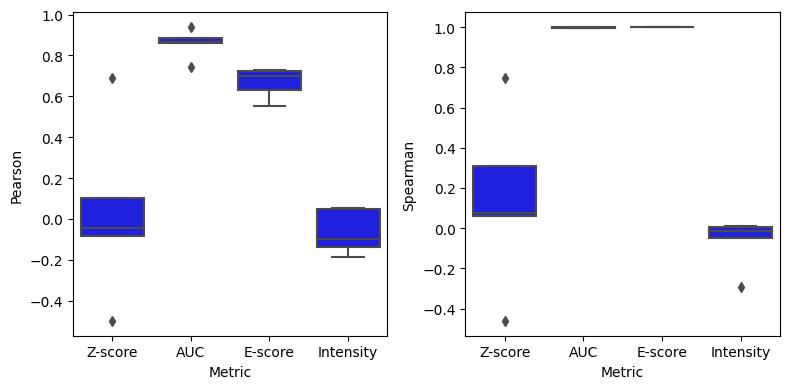

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_ST_long, x="Metric", y="Pearson", color="blue", ax=ax[0])
sns.boxplot(data=spearman_ST_long, x="Metric", y="Spearman", color="blue", ax=ax[1])
plt.tight_layout()

In [178]:
pearson_ST_long["Model"] = "SingleTask"
spearman_ST_long["Model"] = "SingleTask"

## Multi-task DeepBind

In [179]:
# Also need the multi-task columns (single task we could train on all the columns)
sdata_training = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_MT_sub.h5sd"))
target_mask_MT = sdata_training.seqs_annot.columns.str.contains("RNCMPT")
target_cols_MT = sdata_training.seqs_annot.columns[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [180]:
print("Testing DeepBind MultiTask model on")
version = 0
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = eu.models.DeepBind.load_from_checkpoint(model_file)
eu.settings.dl_num_workers = 0
eu.predict.predictions(
    model,
    sdata=sdata_test, 
    target=target_cols_MT,
    name="DeepBind_MT",
    version=f"v{version}",
    file_label="test",
    suffix="_MT"
)
del model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Testing DeepBind MultiTask model on
No transforms given, assuming just need to tensorize).


/home/vscode/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00013_predictions_MT, RNCMPT00289_predictions_MT, RNCMPT00081_predictions_MT, RNCMPT00146_predictions_MT, RNCMPT00079_predictions_MT, RNCMPT00180_predictions_MT, RNCMPT00240_predictions_MT, RNCMPT00050_predictions_MT, RNCMPT00031_predictions_MT, RNCMPT00112_predictions_MT, RNCMPT00219_predictions_MT, RNCMPT00131_predictions_MT, RNCMPT00181_predictions_MT, RNCMPT00096_predictions_MT, RNCMPT00160_predictions_MT, RNCMPT00291_predictions_MT, RNCMPT00282_predictions_MT, RNCMPT00033_predictions_MT, RNCMPT00039_predictions_MT, RNCMPT00249_predictions_MT, RNCMPT00121_predictions_MT, RNCMPT00029_predictions_MT, RNCMPT00170_predictions_MT, RNCMPT00224_predictions_MT, RNCMPT00017_predictions_MT, RNCMPT00172_predictions_MT, RNCMPT00148_predictions_MT, RNCMPT00051_predictions_MT, RNCMPT00086_predictions_MT, RNCMPT00140_predictions_MT, RNCMPT00269_predictions_MT, RNCMPT00197_predictions_MT, RNCMPT00273_predictions_MT, RNCMPT00035_predictions_M

/home/vscode/.local/lib/python3.7/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


In [181]:
pearson_MT_df, spearman_MT_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols[:5], use_calc_auc=True, verbose=False, n_kmers=100, preds_suffix="_predictions_MT")
pearson_MT_long = pearson_MT_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_MT_long = spearman_MT_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_MT_long["Model"] = "MultiTask"
spearman_MT_long["Model"] = "MultiTask"

Evaluating probes:   0%|          | 0/5 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


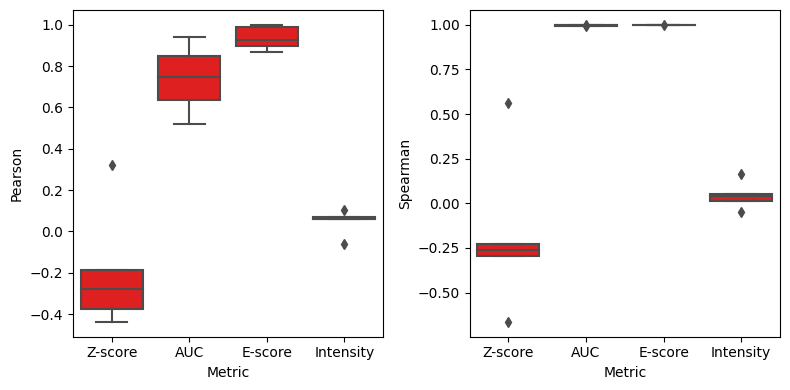

In [182]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_MT_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_MT_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()

# Model comparisons

In [211]:
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))

In [201]:
pearson_setA_long.head()

,RBP,Metric,Pearson,Model
0,RNCMPT00001,AUC,-0.093145,SetA
1,RNCMPT00001,E-score,-0.011105,SetA
2,RNCMPT00002,AUC,-0.114252,SetA
3,RNCMPT00002,E-score,-0.013852,SetA
4,RNCMPT00003,AUC,-0.131226,SetA


In [202]:
pearson_ST_long.head()

,RBP,Metric,Pearson,Model
0,RNCMPT00001,Z-score,-0.498671,SingleTask
1,RNCMPT00002,Z-score,0.691112,SingleTask
2,RNCMPT00003,Z-score,-0.084363,SingleTask
3,RNCMPT00004,Z-score,-0.043655,SingleTask
4,RNCMPT00005,Z-score,0.102972,SingleTask


In [203]:
pearson_MT_long.head()

,RBP,Metric,Pearson,Model
0,RNCMPT00001,Z-score,-0.376919,MultiTask
1,RNCMPT00002,Z-score,-0.277910,MultiTask
2,RNCMPT00003,Z-score,-0.437558,MultiTask
3,RNCMPT00004,Z-score,0.320926,MultiTask
4,RNCMPT00005,Z-score,-0.188840,MultiTask


In [206]:
pearson_long = pd.concat([pearson_setA_long, pearson_MT_long, pearson_ST_long])
spearman_long = pd.concat([spearman_setA_long, spearman_MT_long, spearman_ST_long])
pearson_models = pearson_long.pivot(index=["RBP", "Metric"], columns="Model", values="Pearson").reset_index()
spearman_models = spearman_long.pivot(index=["RBP", "Metric"], columns="Model", values="Spearman").reset_index()

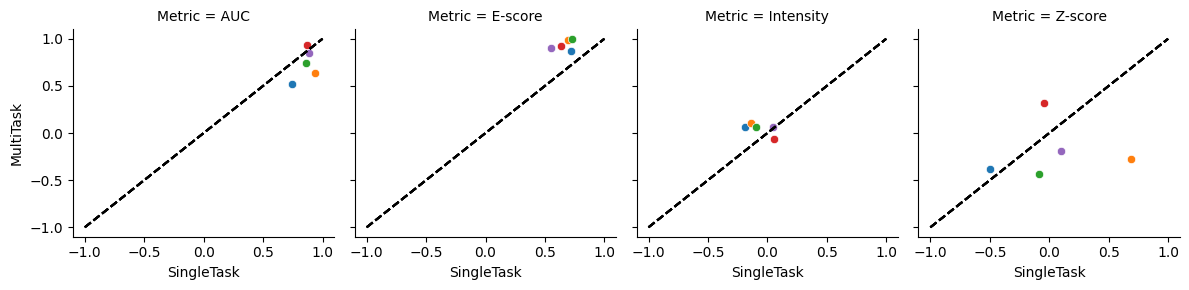

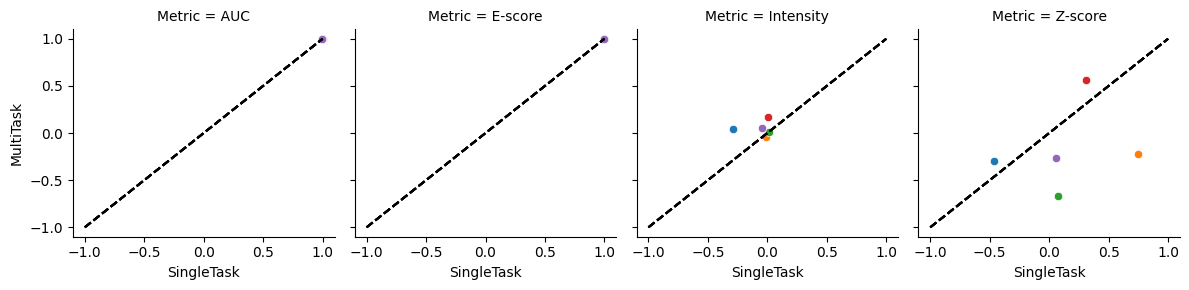

In [207]:
def const_line(*args, **kwargs):
    x = np.arange(-1, 1.01, 0.01)
    plt.plot(x, x, c='k', ls='--')

g = sns.FacetGrid(pearson_models, col="Metric", hue="RBP")
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)

g = sns.FacetGrid(spearman_models, col="Metric", hue="RBP")
g.map(sns.scatterplot, "SingleTask", "MultiTask")
g.map(const_line)

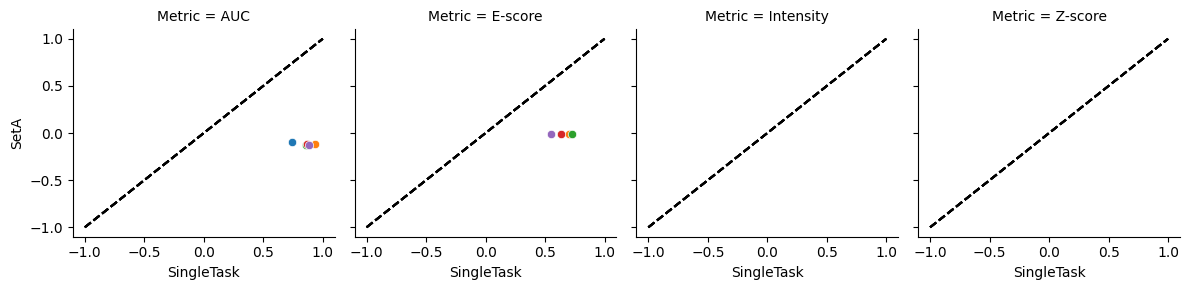

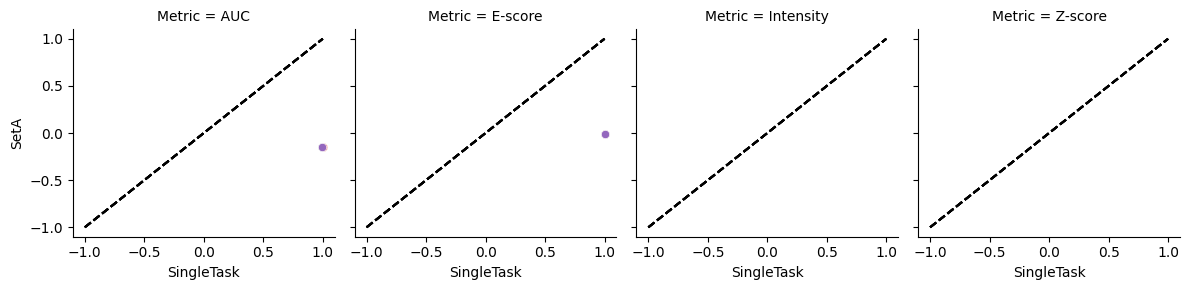

In [209]:
def const_line(*args, **kwargs):
    x = np.arange(-1, 1.01, 0.01)
    plt.plot(x, x, c='k', ls='--')

g = sns.FacetGrid(pearson_models, col="Metric", hue="RBP")
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)

g = sns.FacetGrid(spearman_models, col="Metric", hue="RBP")
g.map(sns.scatterplot, "SingleTask", "SetA")
g.map(const_line)

---

# Scratch

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

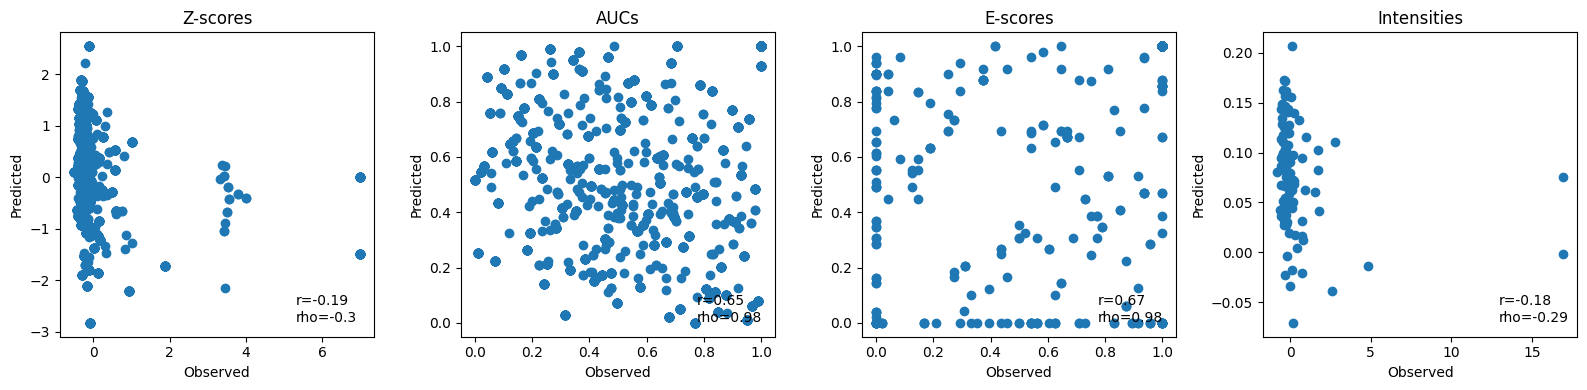

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_ST", use_calc_auc=True, verbose=True, n_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/100 [00:00<?, ?it/s]

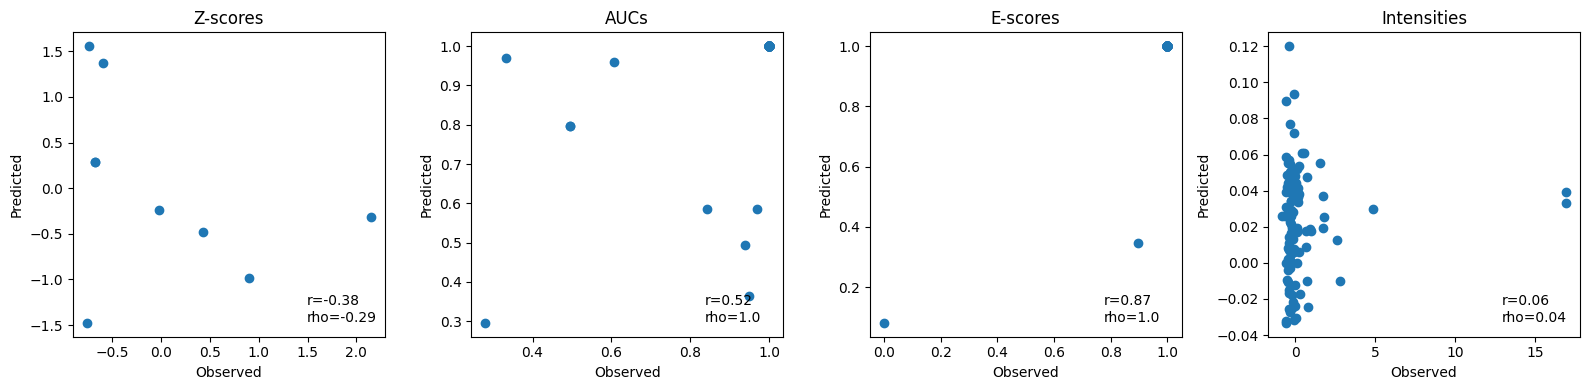

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_MT", use_calc_auc=True, verbose=True, n_kmers=100)